In [1]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from keras.wrappers.scikit_learn import KerasClassifier
import keras
import sklearn
import quantstats as qs
import keras.backend as K

qs.extend_pandas()

Using MXNet backend


## Utility Functions

In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# 1. Case Study: Binary Classification

We will be using the Human Resources Analytics dataset on Kaggle: https://www.kaggle.com/ludobenistant/hr-analytics

We're trying to predict whether an employee will leave based on various features such as number of projects they worked on, time spent at the company, last performance review, salary etc. The dataset has around 15,000 rows and 9 columns. The column we're trying to predict is called "left". It's a binary column with 0/1 values. The label 1 means that the employee has left.


## Data Visualization & Preprocessing

Let’s perform some data visualization and preprocessing before jumping straight into building the model. This part is crucial, since we need to know what type of features we are dealing with. For every ML task, we at least need to answer the following questions:
What type of features do we have: real valued, categorical, or both?
* Do any of the features need normalization?
* Do we have null values?
* What is the label distribution, are the classes imbalanced?
* Is there a correlation between the features?

In [3]:
rawdf = pd.read_csv('../data/ai-use-cases/HR.csv')
rawdf.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,sales,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [4]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   sales                  14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In summary, there are both real and categorical features. There are no null values, but some features need normalization. 76% percent of the examples are labeled as 0, meaning the employee didn’t leave.

In [5]:
rawdf.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,"14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00","14,999.00"
mean,0.61,0.72,3.80,201.05,3.50,0.14,0.02,0.24
std,0.25,0.17,1.23,49.94,1.46,0.35,0.14,0.43
min,0.09,0.36,2.00,96.00,2.00,0.00,0.00,0.00
25%,0.44,0.56,3.00,156.00,3.00,0.00,0.00,0.00
50%,0.64,0.72,4.00,200.00,3.00,0.00,0.00,0.00
75%,0.82,0.87,5.00,245.00,4.00,0.00,0.00,0.00
max,1.00,1.00,7.00,310.00,10.00,1.00,1.00,1.00


In [6]:
employees_who_left = (rawdf['left'].value_counts())/rawdf['left'].count()
employees_who_left

0   0.76
1   0.24
Name: left, dtype: float64

Let’s check the correlation of the features with the labels (the column named “left”). We will use the seaborn package for the correlation plot.§m

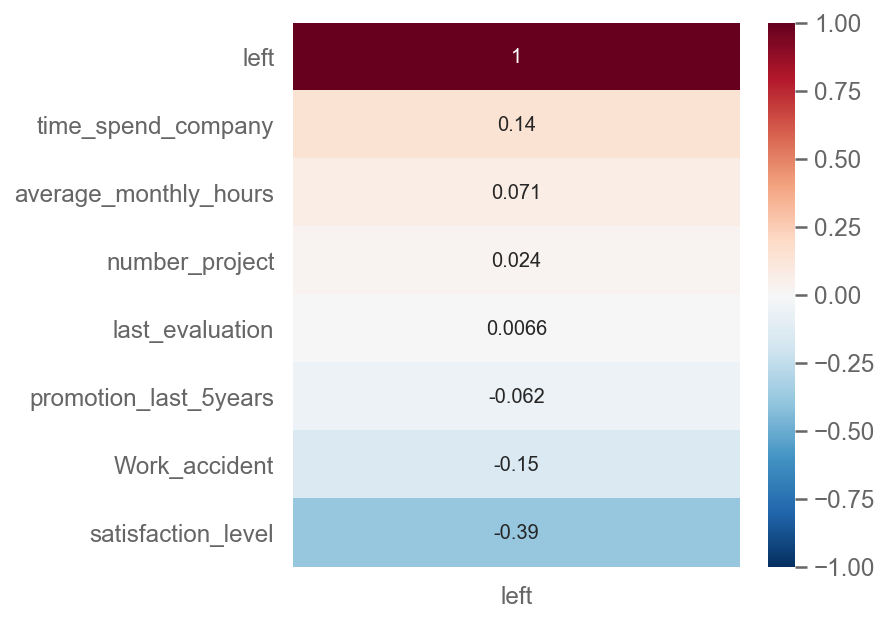

In [7]:
plt.figure(figsize=(5, 5))
result = rawdf.corr()[['left']].sort_values(by=['left'], ascending=False)
sns.heatmap(result, annot=True, vmin=-1, vmax=1, center=0, cmap="RdBu_r")

One feature has a strong signal, which is the “satisfaction_level”, inversely correlated with whether the employee has left. Now let’s look at the pairwise correlation of all features with one another.

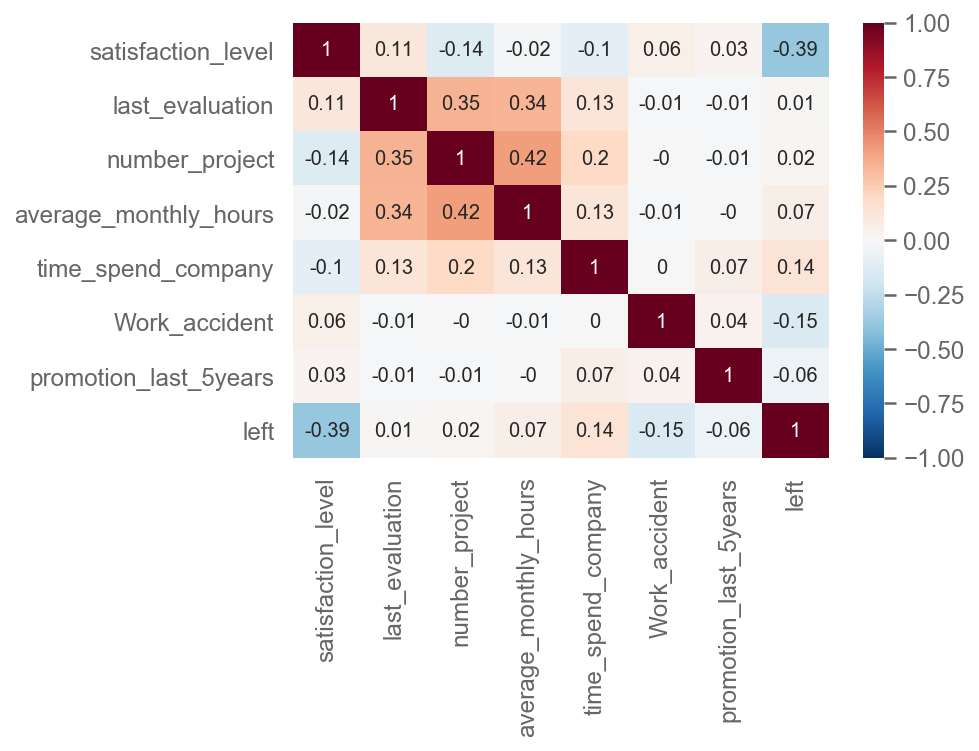

In [8]:
result = rawdf.corr().round(2)
sns.heatmap(result, annot=True, vmin=-1, vmax=1, center=0, cmap="RdBu_r")

We see that “average_monthly_hours” is positively correlated with “number_project”. The more projects a person is involved with, the more hours of work they need to put in.
Now let’s look at the distribution of feature values. By inspecting the histograms of features we can see which ones need normalization. What’s the motivation behind this? What does normalization mean and why is it needed? 


Most ML algorithms perform better if the real valued features are scaled to be in a predefined range, for example [0, 1]. This is particularly important for deep neural networks. If the input features consist of large values, deep nets really struggle to learn. The reason is that as the data flows through the layers, with all the multiplications and additions, it gets large very quickly and this negatively affects the optimization process by saturating non-linearities. We will see the detailed demonstration of this in another article, for now we need to pay attention to feature values to be small numbers.


Looking at feature histograms, we need to normalize 3 of the features: average_monthly_hours, number_project, and time_spend_company. All other features are within [0, 1] so we can leave them alone.

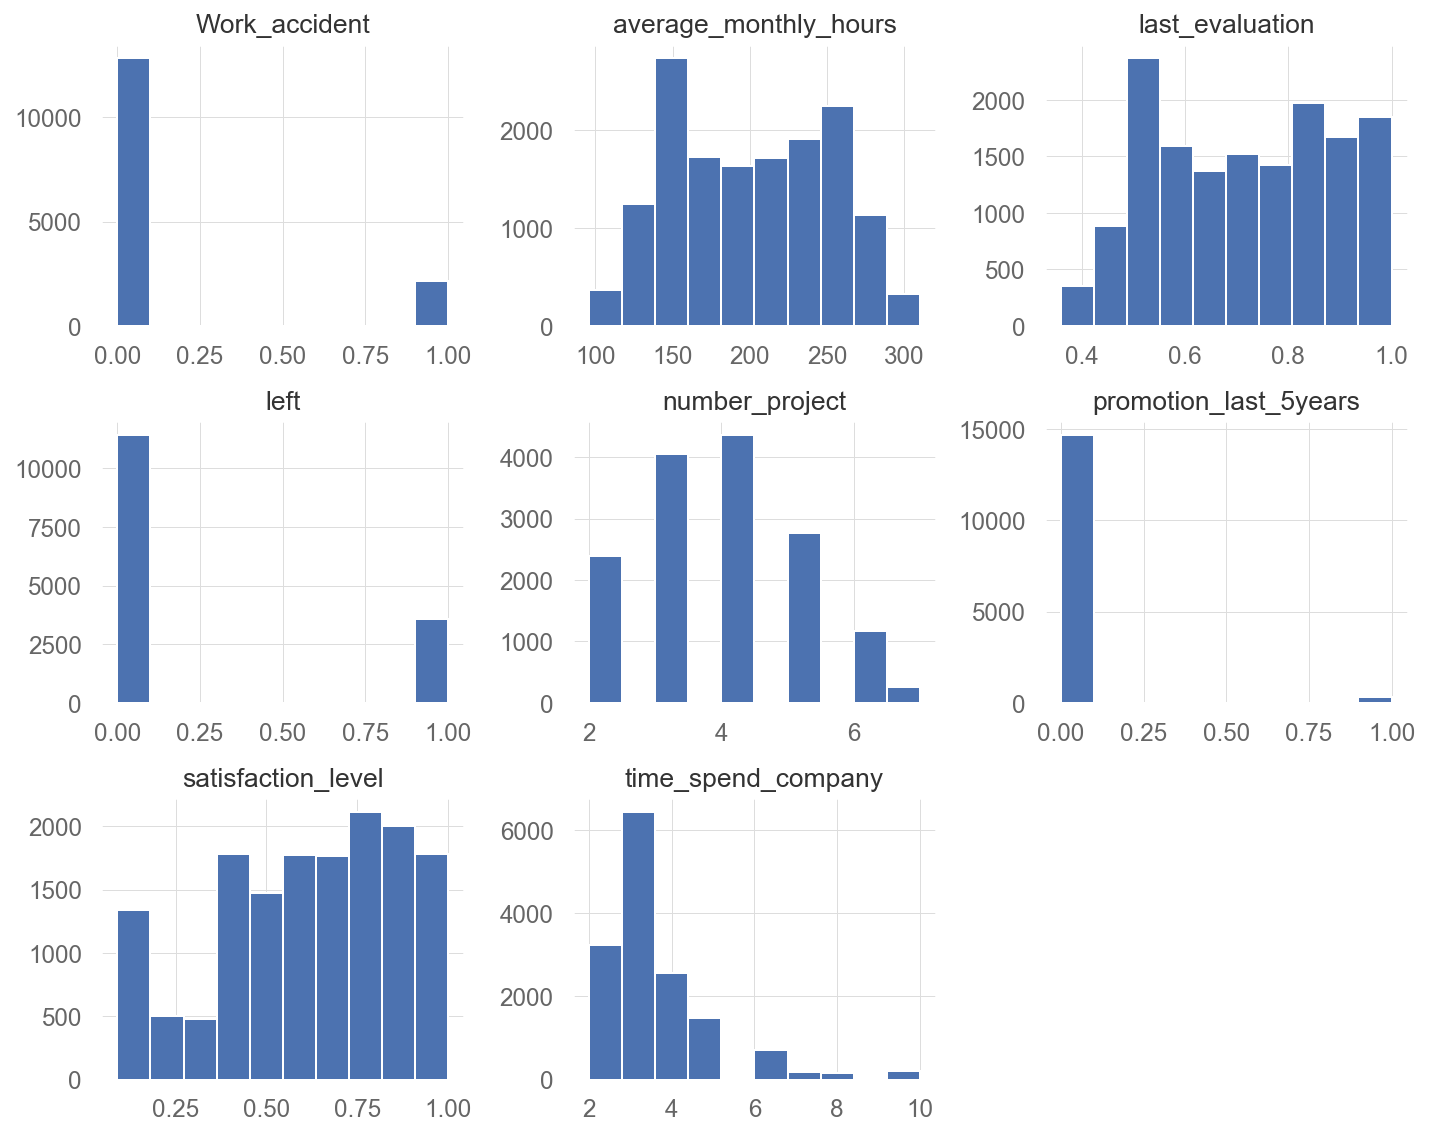

In [9]:
rawdf.hist(figsize=(10, 8))
plt.tight_layout()

Scikit-learn has several normalization methods, what we will use is StandardScaler. It individually scales the features such that they have zero mean and unit variance, so they all belong to a standard Normal(0, 1) distribution. Note that this doesn’t change the ordering of the feature values, it just changes the scale. It’s a simple yet extremely important trick.

We need to convert categorical data to one-hot representation. For example the salary column contains 3 unique string values: low, medium and high. After one-hot conversion we will have 3 new binary columns: salary_low, salary_medium and salary_high. For a given example, only one of them will have the value 1, the others will be 0. We will then drop the original salary column because we don’t need it anymore.

The one-hot conversion is performed by the get_dummies of pandas. We could have also used the OneHotEncoder in scikit-learn, they both get the job done. Since our data is already is in a pandas dataframe, get_dummies is easier. It also automatically perform the renaming of the features.

In [10]:
df = rawdf.copy()

ss = StandardScaler()
scale_features = ['average_monthly_hours', 'number_project', 'time_spend_company']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['sales', 'salary']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,left,sales_IT,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,-1.46,-0.88,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,0.97,1.22,1.71,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,2.59,1.42,0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,0.97,0.44,1.03,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,-1.46,-0.84,-0.34,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


Scikit-learn API is very well designed and contains 4 very commonly used methods. Predictors are ML models like Logistic Regression, and transformers are data manipulators like Standard Scaler.

* fit: For predictors performs training on the given input. For transformers computes the statistics like mean and standard deviation of the input to be used later.
transform: For transformers manipulates the input data using the stats learned by the fit function. We run the transform method after fit since there’s a dependency. Predictors don’t support this method.

* fit_transform: Performs fit + transform in a single call efficiently. For transformers, computes the stats of the input and performs the transformation. It’s very a commonly used method with transformers. For predictors, trains the model and performs prediction on the given input.

* predict: As its name suggests, for predictors performs the prediction task using the model trained with the fit method. Very commonly used with predictors. Transformers don’t support this method.

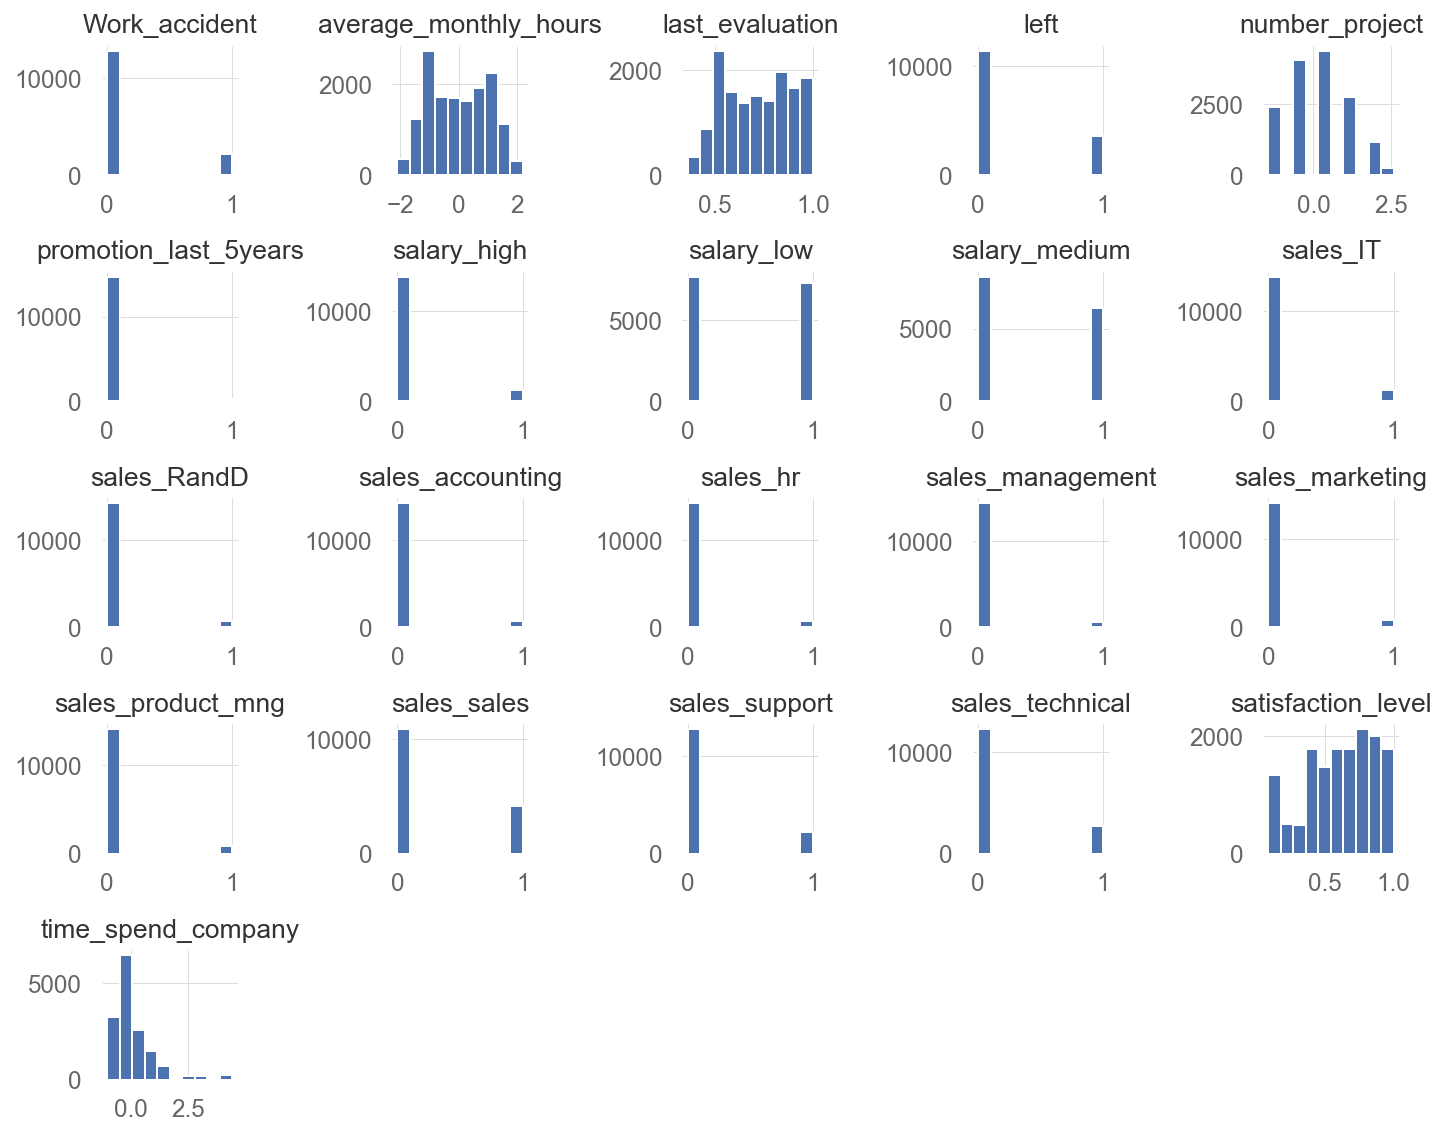

In [11]:
df.hist(figsize=(10, 8))
plt.tight_layout()

In [12]:
df.filter(regex=("salary.*")).head()

,salary_high,salary_low,salary_medium
0,0,1,0
1,0,0,1
2,0,0,1
3,0,1,0
4,0,1,0


Now comes the final part of creating the training and test data. The model will perform learning on the training set and be evaluated on the held-out test set. Scikit-learn has a convenient train_test_split function. We only need to specify the fraction of the test set, in our case 30%. But first we convert our data from pandas dataframe to numpy array using the values attribute of the dataframe.


In [13]:
X = df.drop('left', axis=1).values
y = df['left'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10499, 20) (10499,) (4500, 20) (4500,)


## 1.2) ANN Model
Now that we’re done with the data preprocessing and train/test set generation, here comes the fun part, training the model.

<Figure size 576x432 with 0 Axes>

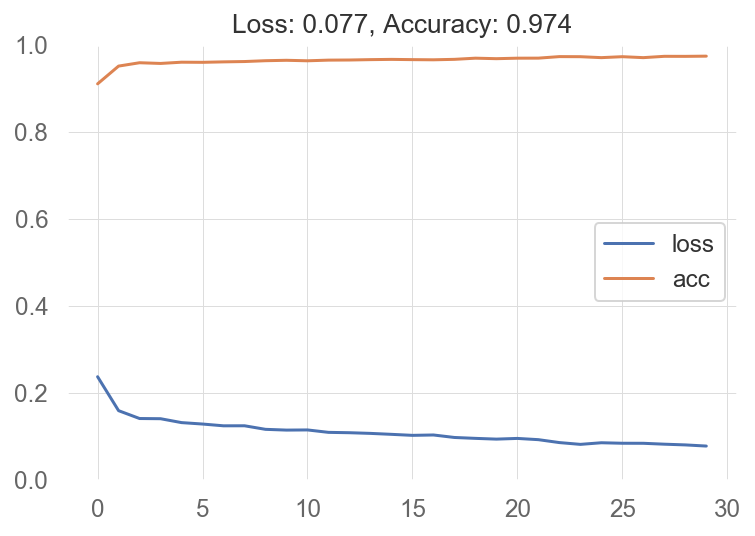

In [14]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model.add(Dense(16, activation='tanh'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(deep_history)

We can further improve the performance of the ANN by doing the following:

* Train the model for longer (increase the number of epochs).

* Hyperparamter tuning: change the learning rate, use a different optimizer than Adam (RMSprop for example), use another activation function than tanh (can be relu).
Increase the number of nodes per layer: Instead of 64–16–1 we can do 128–64–1.

* Increase the number of layers: We can do 128–64–32–16–1.


One important caveat though, as we make the model more powerful, the training loss will likely decrease and accuracy will increase. But we will run into the risk of overfitting. Meaning the complex model will perform worse on the test set compared to a simpler model, even though the training metrics of the complex model is better. We will talk more about overfitting in another article, but this is very important to keep in mind. That’s why we don’t go crazy with number of layers and nodes per layer. The simplest model that gets the job done is sufficient.

## 1.3) Visualization of Deep ANN

Each layer of the ANN performs a non-linear transformation of the input from one vector space to another. By doing this we are projecting our input data to a new space where the classes are separable from each other via a complex decision boundary.


Let’s visually demonstrate this. Our input data after the initial data preprocessing we did above is 20 dimensional. For visualization purposes let’s project it to 2D. Remember that having k nodes in a layer means that this layer transforms its input such that the output is a k-dimensional vector. The ANN we trained above had two hidden layers with 64 and 16 nodes. Then we need a new layer with 2 nodes in order to project our data to a 2D space. So we add this new layer just before the output node. The rest is completely untouched.

<Figure size 576x432 with 0 Axes>

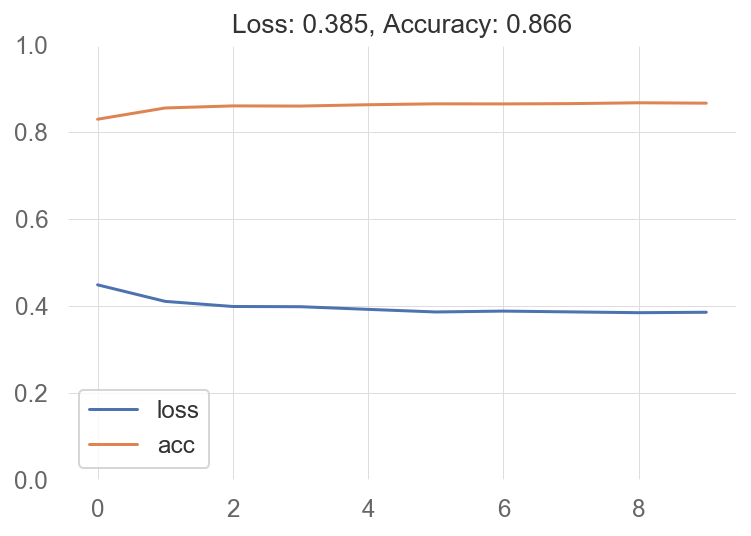

In [15]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
# this is the new layer
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = deep_model_vis.fit(X_train, y_train, verbose=0, epochs=10)
plot_loss_accuracy(history)

In [22]:

# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[2].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[3].input
out2 = deep_model_vis.layers[3].output
func2 = K.function([inp2], [out2])

features = func1([X_test])[0]
# plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
# plt.title('Test Data Separation')

In [23]:
df = pd.read_csv('../data/ai-use-cases/iris.csv')
df.sample(n=5)


,sepal_length,sepal_width,petal_length,petal_width,label
82,5.80,2.70,3.90,1.20,versicolor
139,6.90,3.10,5.40,2.10,virginica
143,6.80,3.20,5.90,2.30,virginica
132,6.40,2.80,5.60,2.20,virginica
86,6.70,3.10,4.70,1.50,versicolor


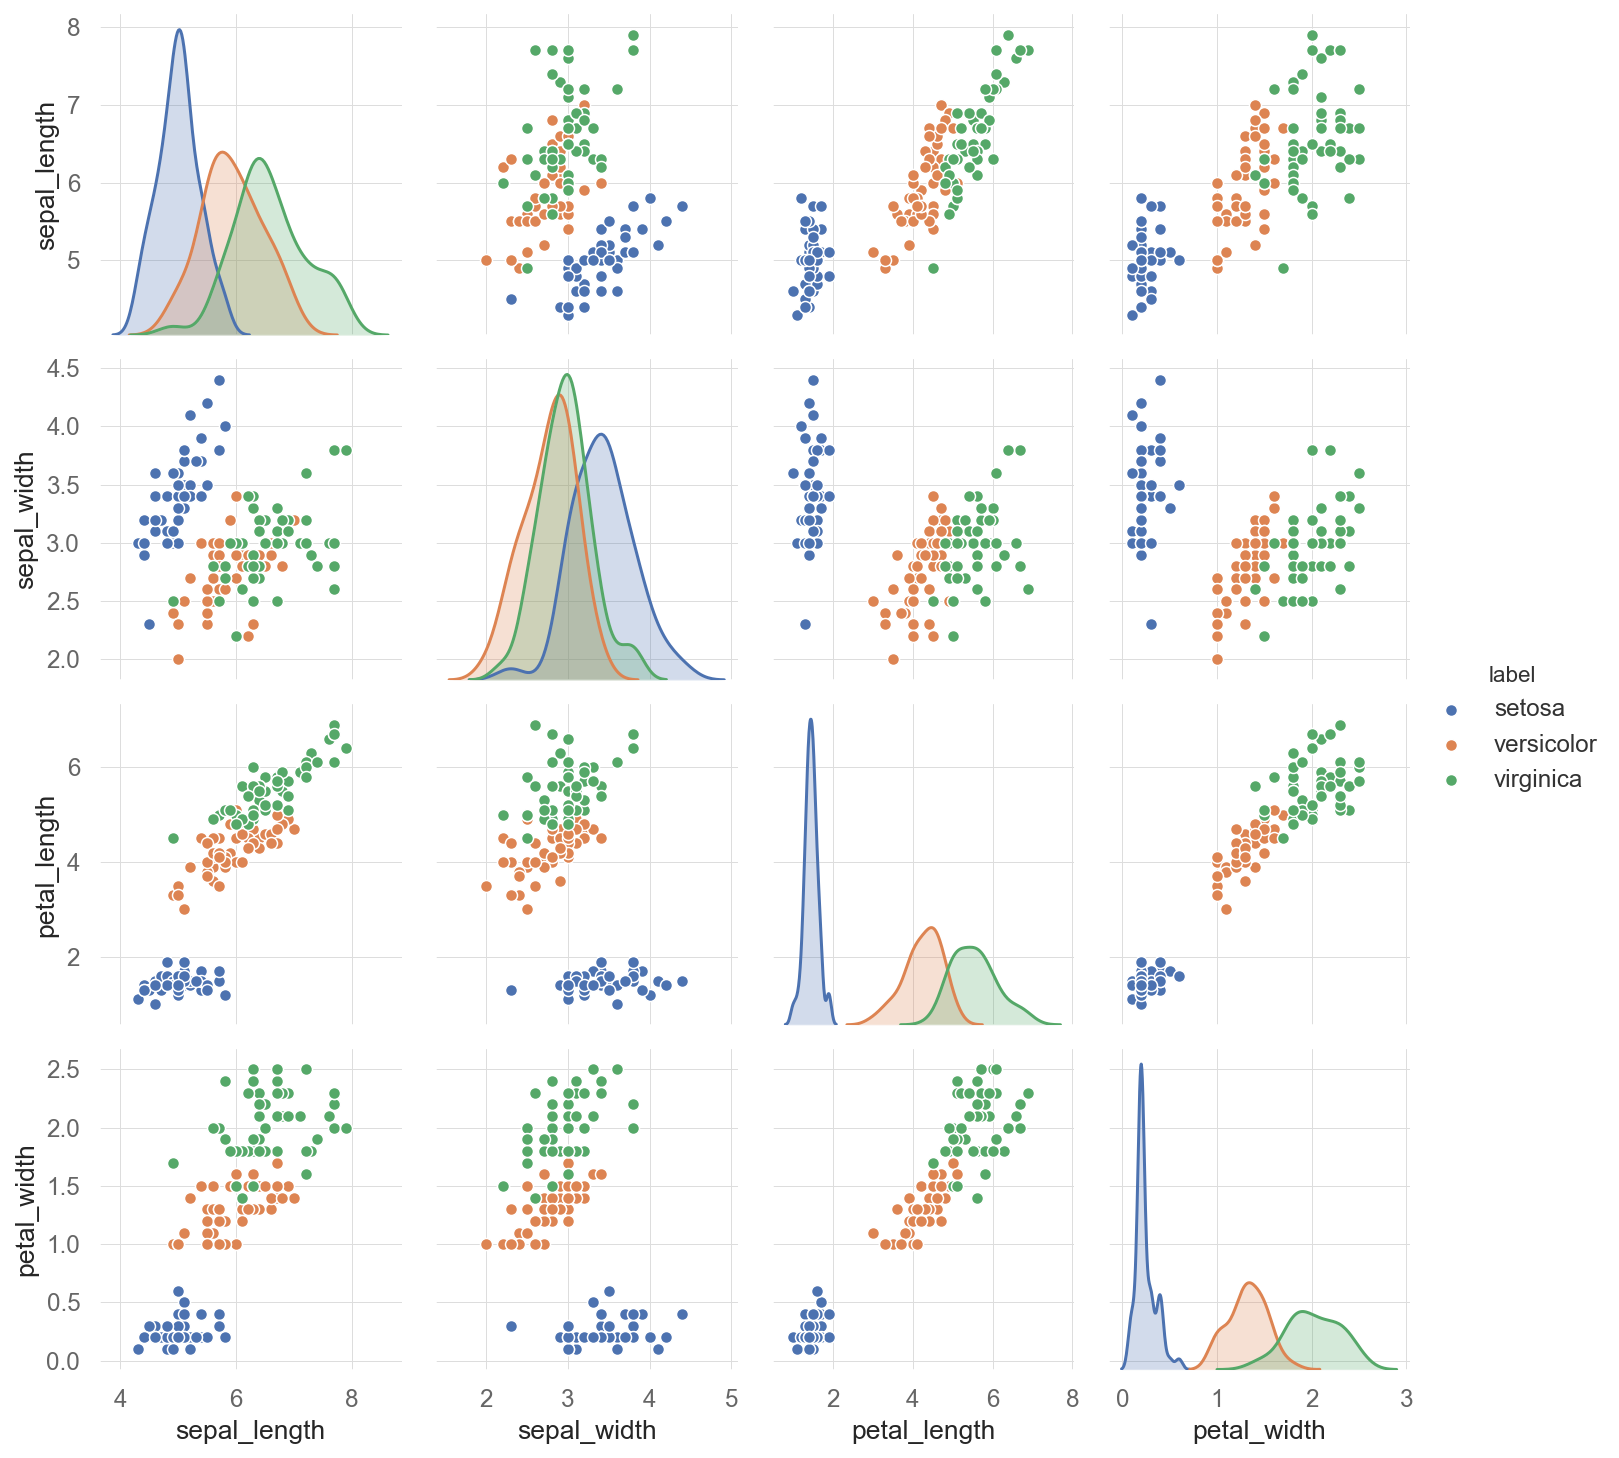

In [24]:
sns.pairplot(df, hue='label')

In [25]:

X = df.values[:, :-1]
ss = StandardScaler()
X = ss.fit_transform(X)
y = pd.get_dummies(df['label']).values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)

(150, 4) (150, 3)
(120, 4) (120, 3)


<Figure size 576x432 with 0 Axes>

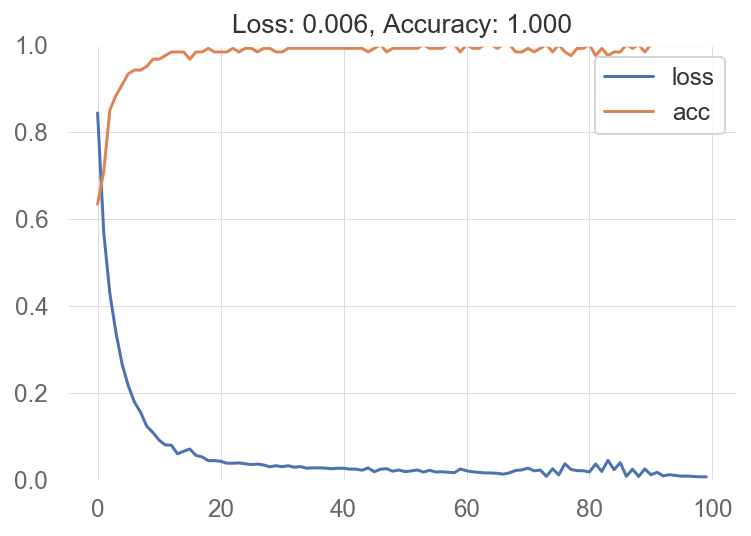

In [26]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(3, activation='softmax'))

deep_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = deep_model.fit(X_train, y_train, epochs=100, verbose=0)
plot_loss_accuracy(history)

precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.85      1.00      0.92        11
           2       1.00      0.78      0.88         9

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



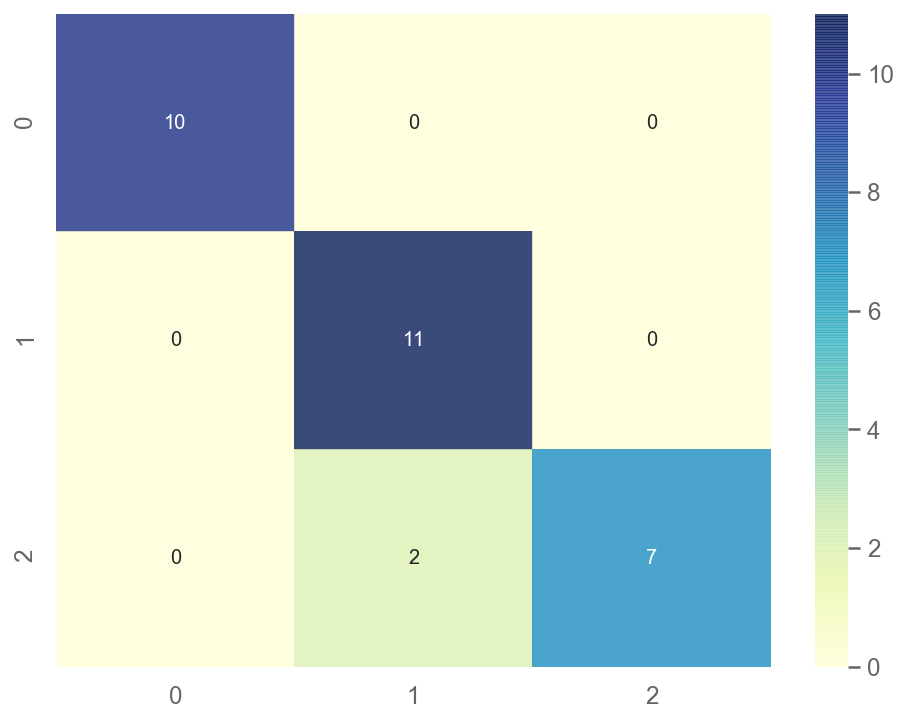

In [27]:
y_pred_class = deep_model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(deep_model, X_test, y_test_class)

## 2.4) Cross Validation
With a small sample size like our current situation, it’s especially important to perform cross validation to get a better estimate on accuracy. With k-fold cross validation we split the dataset into k disjoint parts, use k-1 parts for training and the other 1 part for testing. This way every example appears in both training and test sets. We then average out the model’s performance in all k runs and get a better low-variance estimation of the model accuracy.

<img src="https://miro.medium.com/max/1400/1*Z6NOTHj9rllT_SghGxA3rg@2x.png">

Usually while training deep learning models we don’t perform k-fold cross validation. Because the training takes a long time, and training the model k times from scratch is not feasible. But since our dataset is small it’s a good candidate to try on.

In [28]:
def get_linear_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))
    model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_deep_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cv = StratifiedKFold(n_splits=5, random_state=0)

lin_model = KerasClassifier(build_fn=get_linear_model, epochs=50, verbose=0)
lin_scores = cross_val_score(lin_model, X, df['label'].values, cv=cv)
print(lin_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*lin_scores.mean(), 100*lin_scores.std()*2))

deep_model = KerasClassifier(build_fn=get_deep_model, epochs=50, verbose=0)
deep_scores = cross_val_score(deep_model, X, df['label'].values, cv=cv)
print(deep_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*deep_scores.mean(), 100*deep_scores.std()*2))

[1.         1.         0.93333334 0.93333334 1.        ]
Accuracy: 97.33% (+/- 6.53%)
[0.96666664 0.96666664 0.93333334 0.93333334 1.        ]
Accuracy: 96.00% (+/- 4.99%)


Here’s the plot for 5-fold cross validation accuracy for both models. The deep model is doing slightly better, has a higher accuracy and lower variance. In the figure the accuracies sometimes seem to be above 100% but that’s an artifact of smoothing the curves. 

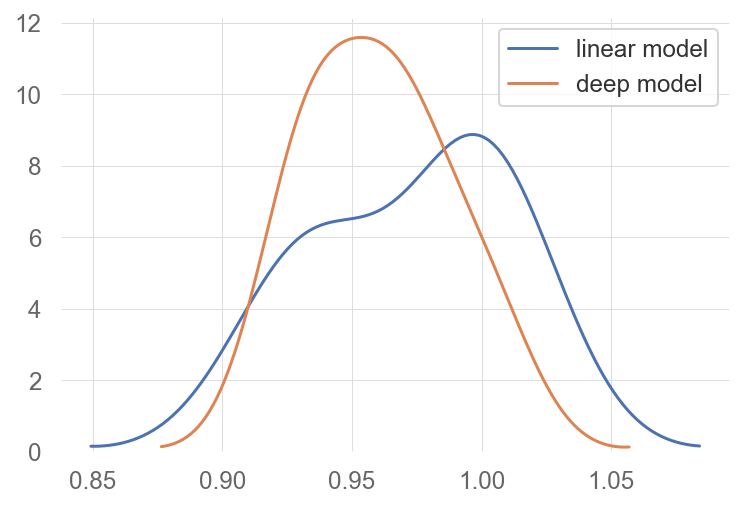

In [33]:
sns.distplot(lin_scores, hist=False, label='linear model')
sns.distplot(deep_scores, hist=False, label='deep model')

# 3. Case Study: Regression
We’ll now work on a regression problem, predicting a real-valued output instead of discreet class memberships. We will be using the [house sales](https://www.kaggle.com/harlfoxem/housesalesprediction) dataset from King County, WA on Kaggle. There are around 21,000 rows with 20 features. The value we’re trying to predict is a floating point number labeled as “price”.

## 3.1) Data Visualization & Preprocessing
First let’s take a look at feature distributions

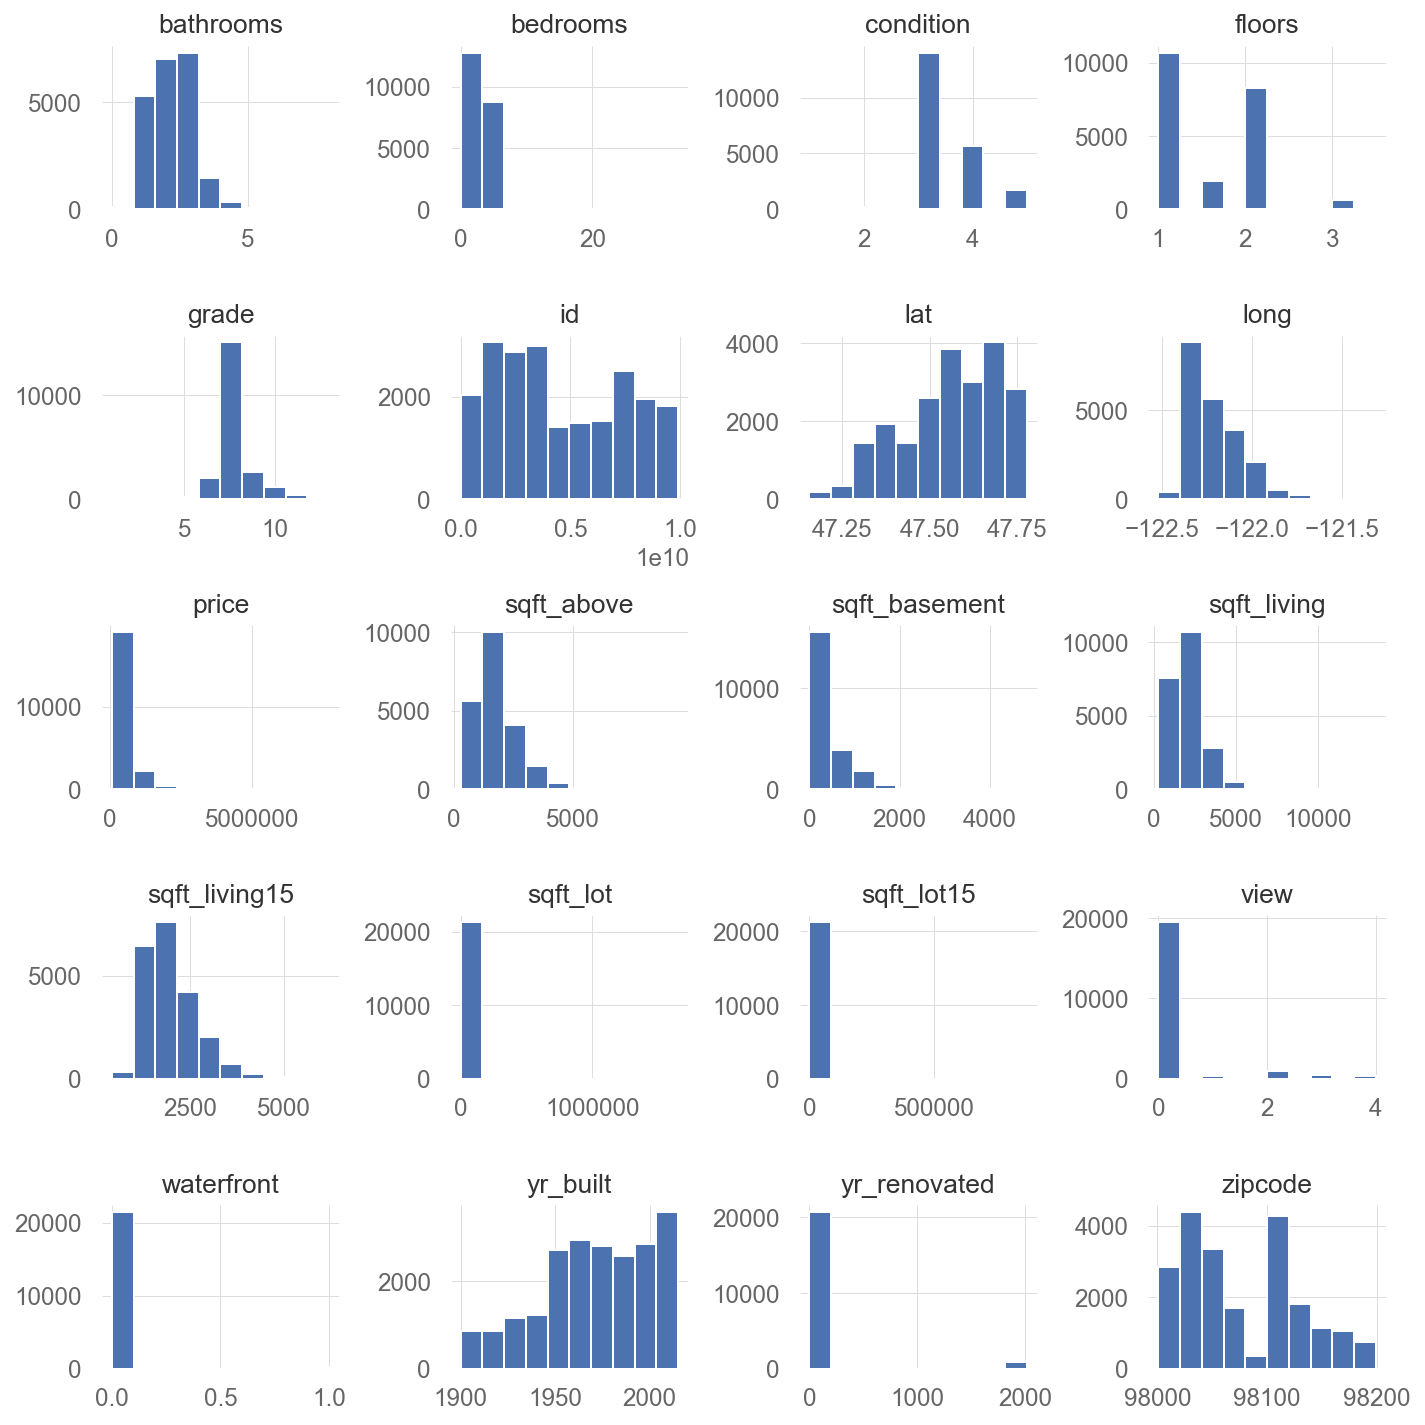

In [3]:
rawdf = pd.read_csv('../data/ai-use-cases/kc_house_data.csv')
rawdf.hist(figsize=(10, 10))
plt.tight_layout()

You know the drill by now, we need to do feature normalization and categorization. For example squarefoot related features definitely need to be normalized since the values range in thousands, and features like zipcode need to be categorized.


We also have a new type of preprocessing to do, bucketization. For example the feature which contains the year the house was built (yr_built), ranges from 1900 to 2015. We can certainly categorize it with every year belonging to a distinct category, but then it would be pretty sparse. We would get more signal if we bucketized this feature without losing much information. For example if we use 10 year buckets, years between 1950, 1959 would be collapsed together. It would probably be sufficient to know that this house was built in 1950s instead of 1958 exactly.


Other features that would benefit from bucketizing are latitude and longitude of the house. The exact coordinate doesn’t matter that much, we can round the coordinate to the nearest kilometer. This way the feature values will be more dense and informative. There’s no hard and set rule to which ranges to use in bucketization, they’re mostly decided by trial and error.


One final transformation we need to do is for the price of the house, the value we’re trying to predict. Currently its value ranges from $75K to $7.7M. A model trying to predict in such a large scale and variance would be very unstable. So we normalize that as well. Feel free to check the code for the details.
After all the transformations we go from 20 to 165 features. Let’s check the correlation of each feature with price.

In [4]:
df = rawdf.copy()

# features that need to be scaled
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 
                  'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])

# bucketized features
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']

bins = range(1890, 2021, 10)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = range(1930, 2021, 10)
bins = [-10] + list(bins)
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])

# categorical features
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in rawdf['date'].values]
df['zipcode'] = df['zipcode'].astype(str)
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# drop features
drop_features = ['id']
df = df.drop(drop_features, axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,date_2014-05,date_2014-06,date_2014-07,date_2014-08,date_2014-09,date_2014-10,date_2014-11,date_2014-12,date_2015-01,date_2015-02,date_2015-03,date_2015-04,date_2015-05,yr_built_1890,yr_built_1900,yr_built_1910,yr_built_1920,yr_built_1930,yr_built_1940,yr_built_1950,yr_built_1960,yr_built_1970,yr_built_1980,yr_built_1990,yr_built_2000,yr_built_2010,yr_renovated_-10,yr_renovated_1930,yr_renovated_1940,yr_renovated_1950,yr_renovated_1960,yr_renovated_1970,yr_renovated_1980,yr_renovated_1990,yr_renovated_2000,yr_renovated_2010,lat_47.0,lat_47.05,lat_47.099999999999994,lat_47.14999999999999,lat_47.19999999999999,lat_47.249999999999986,lat_47.29999999999998,lat_47.34999999999998,lat_47.39999999999998,lat_47.449999999999974,lat_47.49999999999997,lat_47.54999999999997,lat_47.599999999999966,lat_47.64999999999996,lat_47.69999999999996,lat_47.74999999999996,lat_47.799999999999955,long_-122.6,long_-122.55,long_-122.5,long_-122.45,long_-122.4,long_-122.35000000000001,long_-122.30000000000001,long_-122.25000000000001,long_-122.20000000000002,long_-122.15000000000002,long_-122.10000000000002,long_-122.05000000000003,long_-122.00000000000003,long_-121.95000000000003,long_-121.90000000000003,long_-121.85000000000004,long_-121.80000000000004,long_-121.75000000000004,long_-121.70000000000005,long_-121.65000000000005,long_-121.60000000000005,long_-121.55000000000005,long_-121.50000000000006,long_-121.45000000000006,long_-121.40000000000006,long_-121.35000000000007,long_-121.30000000000007,long_-121.25000000000007,long_-121.20000000000007
0,"221,900.00",-0.40,-1.45,-0.98,-0.23,1.00,0,0,3,-0.56,-0.73,-0.66,-0.94,-0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"538,000.00",-0.40,0.18,0.53,-0.19,2.00,0,0,3,-0.56,0.46,0.25,-0.43,-0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"180,000.00",-1.47,-1.45,-1.43,-0.12,1.00,0,0,3,-1.41,-1.23,-0.66,1.07,-0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"604,000.00",0.68,1.15,-0.13,-0.24,1.00,0,0,5,-0.56,-0.89,1.40,-0.91,-0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

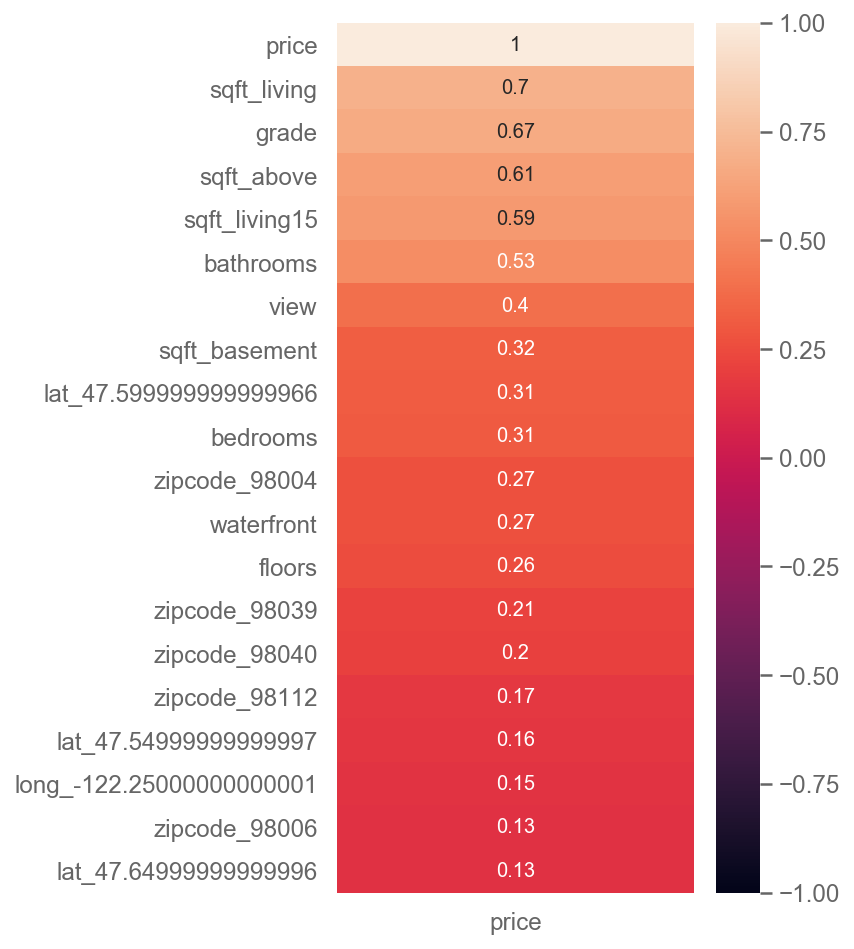

In [5]:
plt.figure(figsize=(4, 8))
tempdf = df.corr()[['price']].sort_values('price', ascending=False).iloc[:20, :]
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

The most correlated feature is the square footage, which is expected, bigger houses are usually more expensive. Looking at the list the features make sense. Some zipcodes have high correlation with price, for example 98039 which corresponds to Medina, that’s where Bill Gates lives and it’s one of the most expensive neighborhoods in the country. There’s another zipcode 98004 which is more correlated corresponding to Bellevue. There are a lot of high-rises and tech offices there, which has been driving up the prices a lot lately.

In [13]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# outlier sanitization of the training set
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()

# scale the price
ss_price = StandardScaler()
y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)
y_train = ss_price.fit_transform(y_train)
y_test = ss_price.fit_transform(y_test)

(17290, 165) (17290,) (4323, 165) (4323,)


In [14]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

ValueError: Error when checking target: expected dense_4 to have shape (1,) but got array with shape (17290,)

In [15]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
#                               callbacks=[early_stop])
plot_loss(deep_history)

ValueError: Error when checking target: expected dense_8 to have shape (1,) but got array with shape (17290,)